In [6]:
from queue import Queue
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array, dstack
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, LayerNormalization, Dense, Attention, MultiHeadAttention, Lambda
from tensorflow.keras.models import Model
# import pygame
import sys
import os
#pygame.init()
# engine = pyttsx3.init() # object creation
SERIAL_PORT = '/dev/cu.DATN'
# be sure to set this to the same rate used on the Arduino
SERIAL_RATE = 38400
test_counter = 240
queue_size = 240
verbose, epochs, batch_size = 1, 40, 300
dataset_path = "./datatrain/"
trainx_file = "./datatrain/trainx.txt"
trainy_file = "./datatrain/trainy.txt"
testx_file = "./datatrain/testx.txt"
testy_file = "./datatrain/testy.txt"
config_file = "./datatrain/config.txt"
enlarged_dataset_path = "./datatrain/model/"


# screen_width = 800
# screen_height = 600
# screen = pygame.display.set_mode((screen_width, screen_height))
# pygame.display.set_caption("Real-time Display")

# Set up fonts
#font = pygame.font.Font(None, 36)
#WHITE = (255, 255, 255)
""" RATE"""
#rate = engine.getProperty('rate')   # getting details of current speaking rate
# engine.setProperty('rate', 125)     # setting up new voice rate
"""VOLUME"""
#volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
#print (volume)                          #printing current volume level
# engine.setProperty('volume',1.0)    # setting up volume level  between 0 and 1

"""VOICE"""
#voices = engine.getProperty('voices')       #getting details of current voice
#engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
# engine.setProperty('voice', engine.getProperty('voices')[1].id)   #changing index, changes voices. 1 for female

# def textToSpeech(text):
#     engine.say(text)
#     engine.runAndWait()
#     engine.stop()
    

def readConfig():
    with open('./datatrain/config.txt', 'r',encoding='utf-8') as file:
        # Initialize an empty 2D array
        config = []

        # Iterate over each line in the file
        for line in file:
            # Split the line into individual words
            words = line.strip()

            # Append the words to the 2D array
            config.append(words)
        return config

def readdata(trainx_file, trainy_file, testx_file, testy_file):
    trainx_data =[]
    trainy_data =[]
    testx_data =[]
    testy_data =[]
    with open(trainx_file, 'r') as trainx, open(trainy_file, 'r') as trainy, open(testx_file, 'r') as testx, open(testy_file, 'r') as testy  :
        trainy_data = extract_y(trainy)
        testy_data = extract_y(testy)
        
        trainx_data = extract_data(trainx)
        testx_data = extract_data(testx)

    trainx_data = np.vstack(trainx_data)
    testx_data = np.vstack(testx_data)
    trainy_data = to_categorical(trainy_data)
    testy_data = to_categorical(testy_data)
    return trainx_data, trainy_data, testx_data, testy_data

def extract_data(file):
    data = []
    while True:
            try:
                x1 = []
                x2 = []
                x3 = []
                x4 = []
                x5 = []
                x6 = []
                x7 = []
                line = next(file).strip().split()
                if len(line) >= 1680:
                    for i in range(240):
                        x1.append(float(line[i]))
                        x2.append(float(line[i + 240]))
                        x3.append(float(line[i + 480]))
                        x4.append(float(line[i + 720]))
                        x5.append(float(line[i + 960]))
                        x6.append(float(line[i + 1200]))
                        x7.append(float(line[i + 1440]))
                else:
                    print("Error train data.")
                x1 = array(x1)
                x2 = array(x2)
                x3 = array(x3)
                x4 = array(x4)
                x5 = array(x5)
                x6 = array(x6)
                x7 = array(x7)
                line_dataset = dstack([x1, x2, x3, x4, x5, x6, x7]) 
                line_dataset = line_dataset.reshape(1,240,7)
                data.append(line_dataset)
            except StopIteration:
                break
    return data

def extract_y(file):
    y = []
    for line in file:
        y.append(line)
    y = array(y)
    data = np.vstack(y)
    data.reshape(1,len(y))
    return data


In [7]:
def positional_encoding(length, depth):
    depth = int(depth)
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)                # (1, depth)
    angle_rads = positions * angle_rates             # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class AddPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        _, seq_len, d_model = input_shape
        self.pos_encoding = positional_encoding(seq_len, d_model)

    def call(self, inputs):
        # Ensure positional encoding has the same shape as the input
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :tf.shape(inputs)[2]]

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config

In [8]:
def read_enlarged_data():
    data = []
    filenames = []
    for filename in os.listdir(enlarged_dataset_path):
        filenames.append(filename.split('.')[0])
        filepath = os.path.join(enlarged_dataset_path, filename)
        if os.path.isfile(filepath):
            with open(filepath, 'r') as file:
                train_data = np.vstack(extract_data(file))
                data.append(train_data)
    return data, filenames

# def create_model(timesteps, features, num_classes, name = "original_model"):
#     # define model
#     model = Sequential(name=name)
#     model.add(LSTM(units = 128, input_shape = (timesteps, features)))
#     model.add(Dropout(0.5)) 
#     model.add(Flatten())
#     model.add(Dense(units = 64, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model


def create_base_model(timesteps, n_features):
    inputs = Input(shape=(timesteps, n_features))

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = LSTM(units=128, return_sequences=True)(x)
    x = LSTM(units=128, return_sequences=True)(x)

    x = AddPositionalEncoding()(x)

    # MultiHeadAttention layer
    attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
    x = LayerNormalization()(attn_output + x)

    x = Dense(units=128, activation='relu')(x)

    # Global Attention layer
    attn = Attention()([x, x])
    x = LayerNormalization()(attn + x)

    # Global average pooling to reduce sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)


    model = Model(inputs=inputs, outputs= x)
    return model

def add_activation_layer(model, num_classes, name):
    x = Dense(units=num_classes, activation='softmax')(model.output)
    model = Model(inputs=model.input, outputs=x, name=name)
    return model

def evaluate_model(model, testX, testy,  class_names):
    print(f"Evaluate model {model.name}")

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(testy, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(xticks_rotation=60, ax=ax)
    plt.show()
    
def plot_val_loss(models, history):
    for model, h in zip(models, history):
        plt.plot(h.history['val_loss'], label=model.name)
    plt.title('model validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [9]:
trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
class_names = readConfig()
timesteps, n_features, num_classes = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print(f"timesteps: {timesteps}, n_features: {n_features}, num_classes: {num_classes}")

timesteps: 240, n_features: 7, num_classes: 15


Epoch 1/40
3/3 [==============================] - 7s 750ms/step - loss: 2.7844 - accuracy: 0.1339 - val_loss: 3.0669 - val_accuracy: 0.1531
Epoch 2/40
3/3 [==============================] - 1s 241ms/step - loss: 2.4223 - accuracy: 0.2704 - val_loss: 2.2159 - val_accuracy: 0.1633
Epoch 3/40
3/3 [==============================] - 1s 249ms/step - loss: 1.7831 - accuracy: 0.5204 - val_loss: 1.6305 - val_accuracy: 0.4235
Epoch 4/40
3/3 [==============================] - 1s 243ms/step - loss: 1.2231 - accuracy: 0.6645 - val_loss: 1.4745 - val_accuracy: 0.4592
Epoch 5/40
3/3 [==============================] - 1s 233ms/step - loss: 0.8199 - accuracy: 0.7577 - val_loss: 0.9210 - val_accuracy: 0.5816
Epoch 6/40
3/3 [==============================] - 1s 240ms/step - loss: 0.4971 - accuracy: 0.8661 - val_loss: 0.5907 - val_accuracy: 0.7296
Epoch 7/40
3/3 [==============================] - 1s 233ms/step - loss: 0.3287 - accuracy: 0.9056 - val_loss: 0.4406 - val_accuracy: 0.9082
Epoch 8/40
3/3 [====

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 714ms/step - loss: 3.1190 - accuracy: 0.1722 - val_loss: 2.4672 - val_accuracy: 0.2704
Epoch 2/40
3/3 [==============================] - 1s 240ms/step - loss: 1.6271 - accuracy: 0.5013 - val_loss: 2.1708 - val_accuracy: 0.2959
Epoch 3/40
3/3 [==============================] - 1s 255ms/step - loss: 1.1360 - accuracy: 0.6620 - val_loss: 2.3131 - val_accuracy: 0.2500
Epoch 4/40
3/3 [==============================] - 1s 229ms/step - loss: 0.9026 - accuracy: 0.7270 - val_loss: 2.2293 - val_accuracy: 0.2653


c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 706ms/step - loss: 2.7157 - accuracy: 0.1033 - val_loss: 2.2831 - val_accuracy: 0.2092
Epoch 2/40
3/3 [==============================] - 1s 239ms/step - loss: 2.2883 - accuracy: 0.2589 - val_loss: 1.8908 - val_accuracy: 0.3724
Epoch 3/40
3/3 [==============================] - 1s 238ms/step - loss: 1.6595 - accuracy: 0.6263 - val_loss: 1.6909 - val_accuracy: 0.3469
Epoch 4/40
3/3 [==============================] - 1s 239ms/step - loss: 1.1639 - accuracy: 0.6033 - val_loss: 1.2200 - val_accuracy: 0.5561
Epoch 5/40
3/3 [==============================] - 1s 230ms/step - loss: 0.8055 - accuracy: 0.7883 - val_loss: 0.9771 - val_accuracy: 0.5816
Epoch 6/40
3/3 [==============================] - 1s 236ms/step - loss: 0.5468 - accuracy: 0.8571 - val_loss: 0.8144 - val_accuracy: 0.6327
Epoch 7/40
3/3 [==============================] - 1s 240ms/step - loss: 0.3668 - accuracy: 0.9056 - val_loss: 0.7820 - val_accuracy: 0.6531
Epoch 8/40
3/3 [====

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 712ms/step - loss: 2.8820 - accuracy: 0.1020 - val_loss: 2.5733 - val_accuracy: 0.1531
Epoch 2/40
3/3 [==============================] - 1s 221ms/step - loss: 2.5247 - accuracy: 0.1798 - val_loss: 2.1229 - val_accuracy: 0.2959
Epoch 3/40
3/3 [==============================] - 1s 222ms/step - loss: 2.0376 - accuracy: 0.4120 - val_loss: 2.0179 - val_accuracy: 0.2653
Epoch 4/40
3/3 [==============================] - 1s 234ms/step - loss: 1.6191 - accuracy: 0.5204 - val_loss: 1.5636 - val_accuracy: 0.4184
Epoch 5/40
3/3 [==============================] - 1s 227ms/step - loss: 1.1564 - accuracy: 0.7270 - val_loss: 1.1018 - val_accuracy: 0.6122
Epoch 6/40
3/3 [==============================] - 1s 223ms/step - loss: 0.7342 - accuracy: 0.8087 - val_loss: 0.8665 - val_accuracy: 0.5867
Epoch 7/40
3/3 [==============================] - 1s 239ms/step - loss: 0.4874 - accuracy: 0.8737 - val_loss: 0.5350 - val_accuracy: 0.8316
Epoch 8/40
3/3 [====

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 10s 816ms/step - loss: 2.9980 - accuracy: 0.1110 - val_loss: 2.4324 - val_accuracy: 0.2551
Epoch 2/40
3/3 [==============================] - 1s 238ms/step - loss: 2.5992 - accuracy: 0.1454 - val_loss: 2.4009 - val_accuracy: 0.1633
Epoch 3/40
3/3 [==============================] - 1s 236ms/step - loss: 2.2532 - accuracy: 0.2691 - val_loss: 2.2303 - val_accuracy: 0.2908
Epoch 4/40
3/3 [==============================] - 1s 232ms/step - loss: 1.8785 - accuracy: 0.4681 - val_loss: 2.0305 - val_accuracy: 0.4031
Epoch 5/40
3/3 [==============================] - 1s 237ms/step - loss: 1.5228 - accuracy: 0.5536 - val_loss: 1.7596 - val_accuracy: 0.3878
Epoch 6/40
3/3 [==============================] - 1s 234ms/step - loss: 1.2453 - accuracy: 0.6071 - val_loss: 1.7171 - val_accuracy: 0.4184
Epoch 7/40
3/3 [==============================] - 1s 242ms/step - loss: 1.0174 - accuracy: 0.7207 - val_loss: 1.4462 - val_accuracy: 0.5051
Epoch 8/40
3/3 [===

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 717ms/step - loss: 2.7447 - accuracy: 0.1008 - val_loss: 2.6317 - val_accuracy: 0.0000e+00
Epoch 2/40
3/3 [==============================] - 1s 225ms/step - loss: 2.3180 - accuracy: 0.2309 - val_loss: 2.0831 - val_accuracy: 0.1735
Epoch 3/40
3/3 [==============================] - 1s 222ms/step - loss: 1.8862 - accuracy: 0.4056 - val_loss: 1.6095 - val_accuracy: 0.5102
Epoch 4/40
3/3 [==============================] - 1s 222ms/step - loss: 1.3638 - accuracy: 0.6339 - val_loss: 1.2808 - val_accuracy: 0.5969
Epoch 5/40
3/3 [==============================] - 1s 225ms/step - loss: 0.8994 - accuracy: 0.7883 - val_loss: 0.8806 - val_accuracy: 0.7398
Epoch 6/40
3/3 [==============================] - 1s 226ms/step - loss: 0.5605 - accuracy: 0.8954 - val_loss: 0.5533 - val_accuracy: 0.8520
Epoch 7/40
3/3 [==============================] - 1s 222ms/step - loss: 0.3469 - accuracy: 0.9298 - val_loss: 0.4606 - val_accuracy: 0.8929
Epoch 8/40
3/3 [

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 840ms/step - loss: 2.9540 - accuracy: 0.0536 - val_loss: 2.8888 - val_accuracy: 0.0051
Epoch 2/40
3/3 [==============================] - 1s 225ms/step - loss: 2.4801 - accuracy: 0.2041 - val_loss: 2.2275 - val_accuracy: 0.4745
Epoch 3/40
3/3 [==============================] - 1s 221ms/step - loss: 2.1154 - accuracy: 0.3763 - val_loss: 1.9938 - val_accuracy: 0.5051
Epoch 4/40
3/3 [==============================] - 1s 227ms/step - loss: 1.6716 - accuracy: 0.5344 - val_loss: 1.7556 - val_accuracy: 0.4592
Epoch 5/40
3/3 [==============================] - 1s 226ms/step - loss: 1.3027 - accuracy: 0.6276 - val_loss: 1.4345 - val_accuracy: 0.5663
Epoch 6/40
3/3 [==============================] - 1s 224ms/step - loss: 1.0507 - accuracy: 0.7360 - val_loss: 1.2257 - val_accuracy: 0.6684
Epoch 7/40
3/3 [==============================] - 1s 227ms/step - loss: 0.8428 - accuracy: 0.7551 - val_loss: 1.1296 - val_accuracy: 0.6582
Epoch 8/40
3/3 [====

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 711ms/step - loss: 2.8167 - accuracy: 0.1059 - val_loss: 2.5679 - val_accuracy: 0.1531
Epoch 2/40
3/3 [==============================] - 1s 217ms/step - loss: 2.2993 - accuracy: 0.3903 - val_loss: 1.9383 - val_accuracy: 0.5000
Epoch 3/40
3/3 [==============================] - 1s 219ms/step - loss: 1.7265 - accuracy: 0.5485 - val_loss: 1.5220 - val_accuracy: 0.5663
Epoch 4/40
3/3 [==============================] - 1s 222ms/step - loss: 1.2310 - accuracy: 0.6977 - val_loss: 1.1691 - val_accuracy: 0.5663
Epoch 5/40
3/3 [==============================] - 1s 226ms/step - loss: 0.7846 - accuracy: 0.7423 - val_loss: 0.8192 - val_accuracy: 0.6735
Epoch 6/40
3/3 [==============================] - 1s 221ms/step - loss: 0.5245 - accuracy: 0.8495 - val_loss: 0.5652 - val_accuracy: 0.8418
Epoch 7/40
3/3 [==============================] - 1s 220ms/step - loss: 0.3879 - accuracy: 0.8827 - val_loss: 0.4552 - val_accuracy: 0.8520
Epoch 8/40
3/3 [====

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 710ms/step - loss: 2.7359 - accuracy: 0.1224 - val_loss: 2.3769 - val_accuracy: 0.4031
Epoch 2/40
3/3 [==============================] - 1s 223ms/step - loss: 2.2426 - accuracy: 0.3788 - val_loss: 2.0908 - val_accuracy: 0.2041
Epoch 3/40
3/3 [==============================] - 1s 229ms/step - loss: 1.7656 - accuracy: 0.5255 - val_loss: 1.4544 - val_accuracy: 0.7041
Epoch 4/40
3/3 [==============================] - 1s 231ms/step - loss: 1.2860 - accuracy: 0.6709 - val_loss: 1.2120 - val_accuracy: 0.5918
Epoch 5/40
3/3 [==============================] - 1s 227ms/step - loss: 0.9120 - accuracy: 0.7538 - val_loss: 0.7353 - val_accuracy: 0.7704
Epoch 6/40
3/3 [==============================] - 1s 224ms/step - loss: 0.5777 - accuracy: 0.8967 - val_loss: 0.5773 - val_accuracy: 0.8367
Epoch 7/40
3/3 [==============================] - 1s 230ms/step - loss: 0.3662 - accuracy: 0.9260 - val_loss: 0.3046 - val_accuracy: 0.9745
Epoch 8/40
3/3 [====

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 7s 708ms/step - loss: 2.7313 - accuracy: 0.1135 - val_loss: 2.5075 - val_accuracy: 0.0000e+00
Epoch 2/40
3/3 [==============================] - 1s 225ms/step - loss: 2.3755 - accuracy: 0.2577 - val_loss: 2.2059 - val_accuracy: 0.2398
Epoch 3/40
3/3 [==============================] - 1s 218ms/step - loss: 1.9019 - accuracy: 0.4362 - val_loss: 1.7704 - val_accuracy: 0.4898
Epoch 4/40
3/3 [==============================] - 1s 220ms/step - loss: 1.5132 - accuracy: 0.5548 - val_loss: 1.6541 - val_accuracy: 0.4439
Epoch 5/40
3/3 [==============================] - 1s 225ms/step - loss: 1.2002 - accuracy: 0.6454 - val_loss: 1.8213 - val_accuracy: 0.3776
Epoch 6/40
3/3 [==============================] - 1s 226ms/step - loss: 0.9694 - accuracy: 0.6811 - val_loss: 1.5494 - val_accuracy: 0.4847
Epoch 7/40
3/3 [==============================] - 1s 221ms/step - loss: 0.7939 - accuracy: 0.7296 - val_loss: 1.2018 - val_accuracy: 0.5612
Epoch 8/40
3/3 [

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


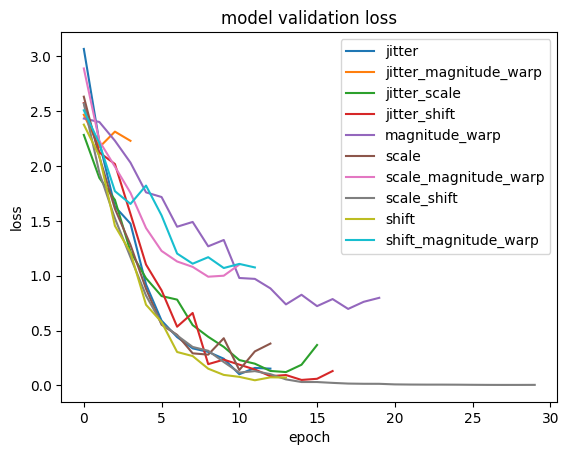

Evaluate model jitter
12/12 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      1.00      1.00        40
     Tốt lắm       1.00      1.00      1.00        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       1.00      1.00      1.00        10
       Đi bộ       1.00      1.00      1.00        20
  Xung quanh       1.00      0.97      0.99        40
    Đùa thôi       1.00      1.00      1.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       1.00      1.00      1.00        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       0.95      1.00      0.98        20

    accuracy                           1.00       370
   m

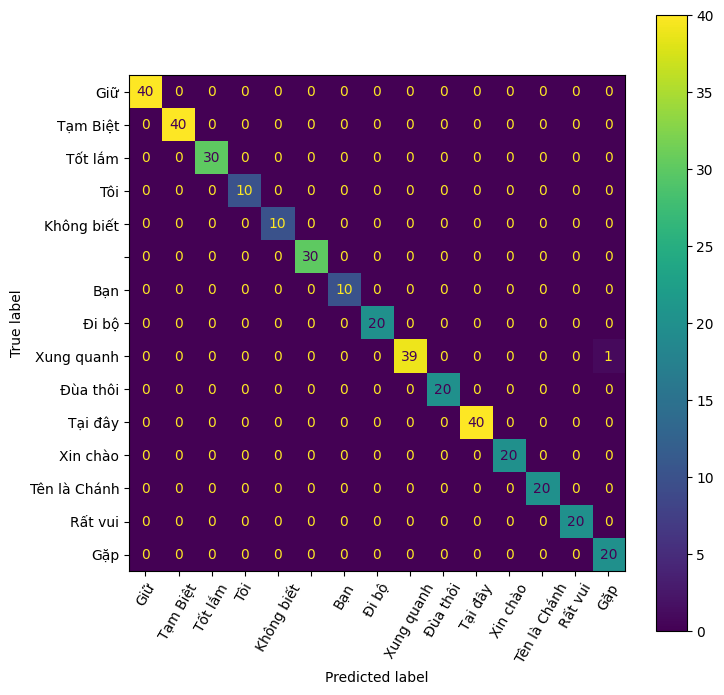

Evaluate model jitter_magnitude_warp
12/12 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

         Giữ       0.93      1.00      0.96        40
    Tạm Biệt       0.97      0.80      0.88        40
     Tốt lắm       0.97      1.00      0.98        30
         Tôi       1.00      0.50      0.67        10
  Không biết       0.67      1.00      0.80        10
                   1.00      0.73      0.85        30
         Bạn       0.82      0.90      0.86        10
       Đi bộ       0.81      0.85      0.83        20
  Xung quanh       1.00      0.82      0.90        40
    Đùa thôi       0.84      0.80      0.82        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       1.00      1.00      1.00        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.62      1.00      0.77        20
         Gặp       0.80      1.00      0.89        20

    accuracy                           0.90

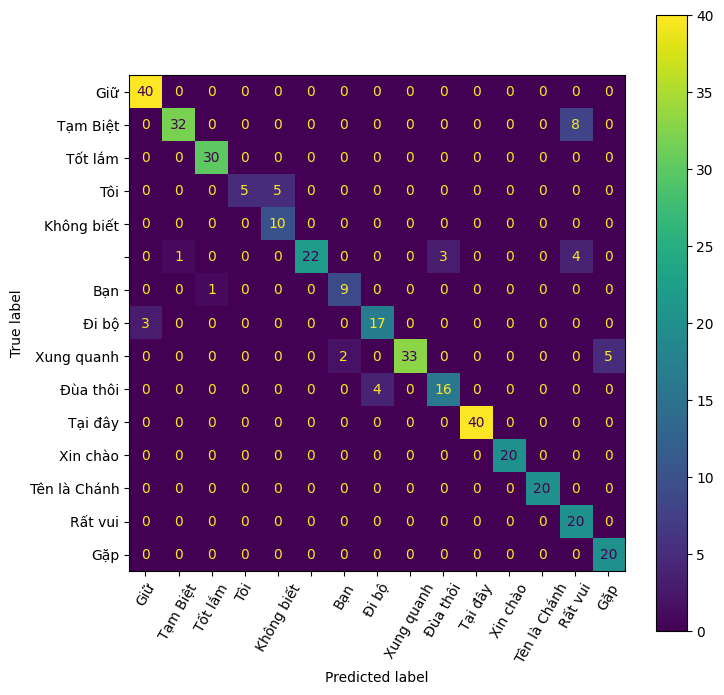

Evaluate model jitter_scale
12/12 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      0.62      0.77        40
     Tốt lắm       1.00      1.00      1.00        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       1.00      1.00      1.00        10
       Đi bộ       1.00      1.00      1.00        20
  Xung quanh       1.00      1.00      1.00        40
    Đùa thôi       1.00      1.00      1.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       0.57      1.00      0.73        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       1.00      1.00      1.00        20

    accuracy                           0.96       37

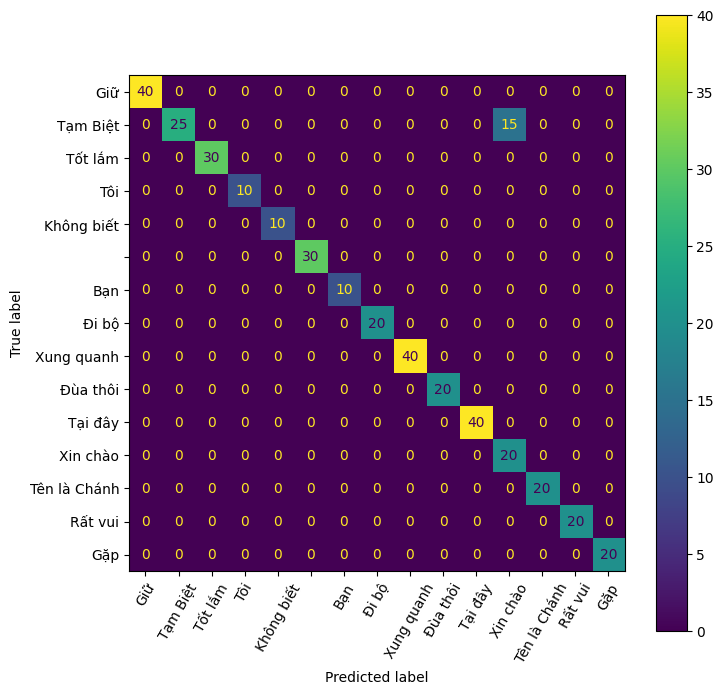

Evaluate model jitter_shift
12/12 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      0.93      0.96        40
     Tốt lắm       1.00      1.00      1.00        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       1.00      1.00      1.00        10
       Đi bộ       1.00      1.00      1.00        20
  Xung quanh       1.00      1.00      1.00        40
    Đùa thôi       1.00      1.00      1.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       0.87      1.00      0.93        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       1.00      1.00      1.00        20

    accuracy                           0.99       37

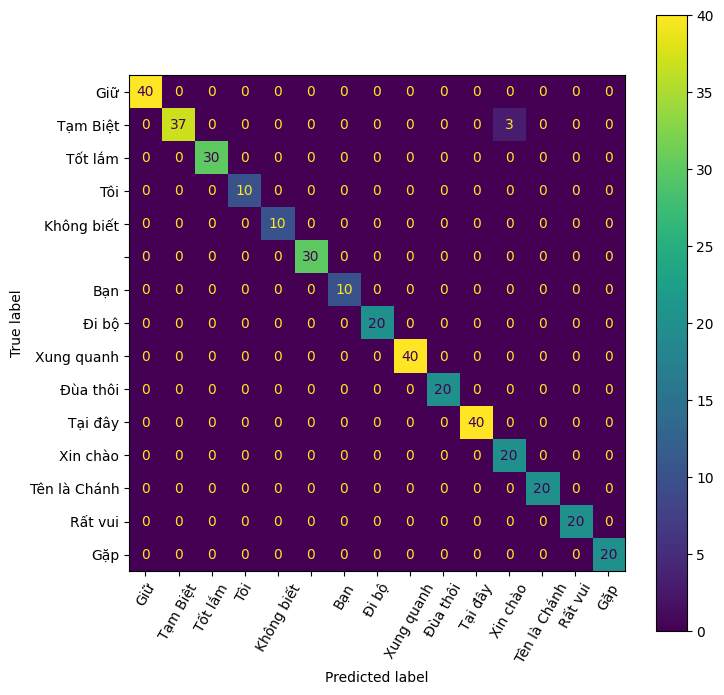

Evaluate model magnitude_warp
12/12 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      1.00      1.00        40
     Tốt lắm       1.00      1.00      1.00        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       1.00      1.00      1.00        10
       Đi bộ       1.00      1.00      1.00        20
  Xung quanh       1.00      1.00      1.00        40
    Đùa thôi       1.00      1.00      1.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       1.00      1.00      1.00        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       1.00      1.00      1.00        20

    accuracy                           1.00       

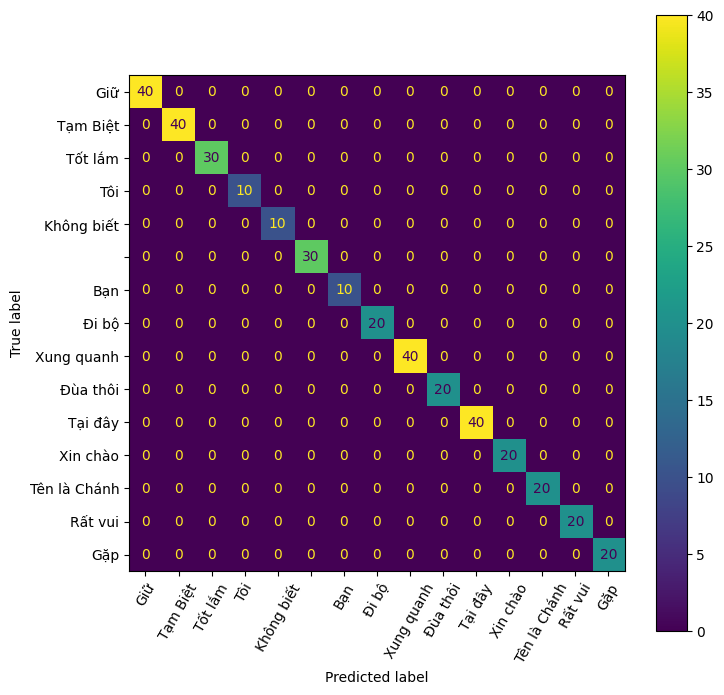

Evaluate model scale
12/12 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      0.78      0.87        40
     Tốt lắm       1.00      1.00      1.00        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       0.91      1.00      0.95        10
       Đi bộ       1.00      1.00      1.00        20
  Xung quanh       1.00      0.97      0.99        40
    Đùa thôi       1.00      1.00      1.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       0.69      1.00      0.82        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       1.00      1.00      1.00        20

    accuracy                           0.97       370
   ma

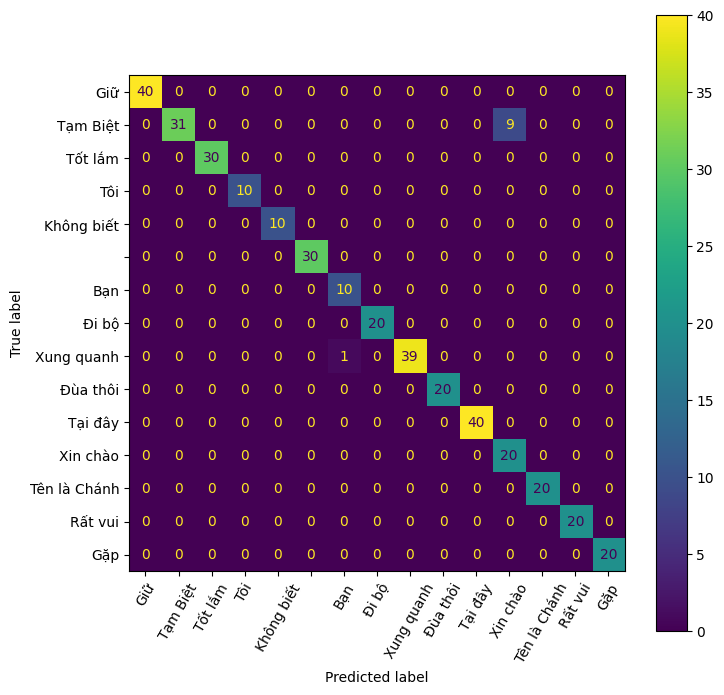

Evaluate model scale_magnitude_warp
12/12 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      0.95      0.97        40
     Tốt lắm       1.00      1.00      1.00        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       1.00      1.00      1.00        10
       Đi bộ       0.95      1.00      0.98        20
  Xung quanh       1.00      1.00      1.00        40
    Đùa thôi       1.00      0.95      0.97        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       0.91      1.00      0.95        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       1.00      1.00      1.00        20

    accuracy                           0.99 

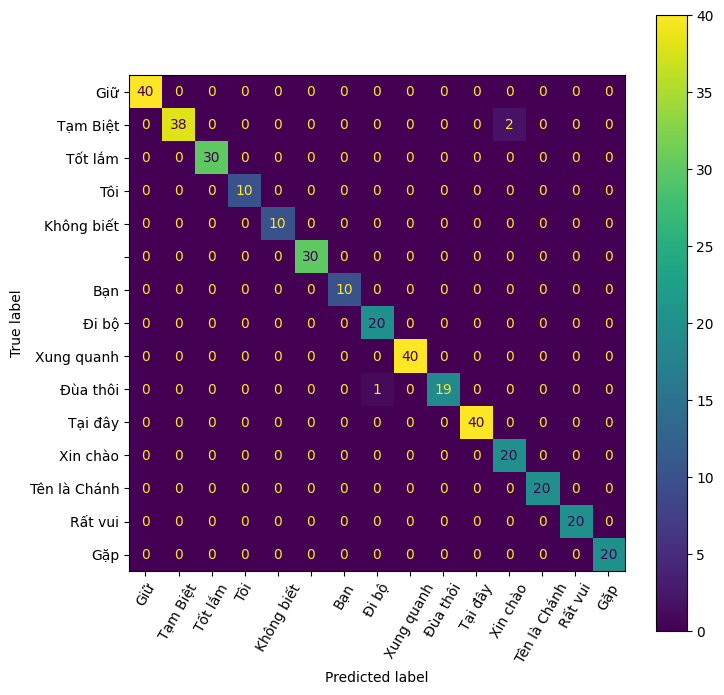

Evaluate model scale_shift
12/12 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      1.00      1.00        40
     Tốt lắm       1.00      1.00      1.00        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       1.00      1.00      1.00        10
       Đi bộ       1.00      1.00      1.00        20
  Xung quanh       1.00      1.00      1.00        40
    Đùa thôi       1.00      1.00      1.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       1.00      1.00      1.00        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       1.00      1.00      1.00        20

    accuracy                           1.00       370

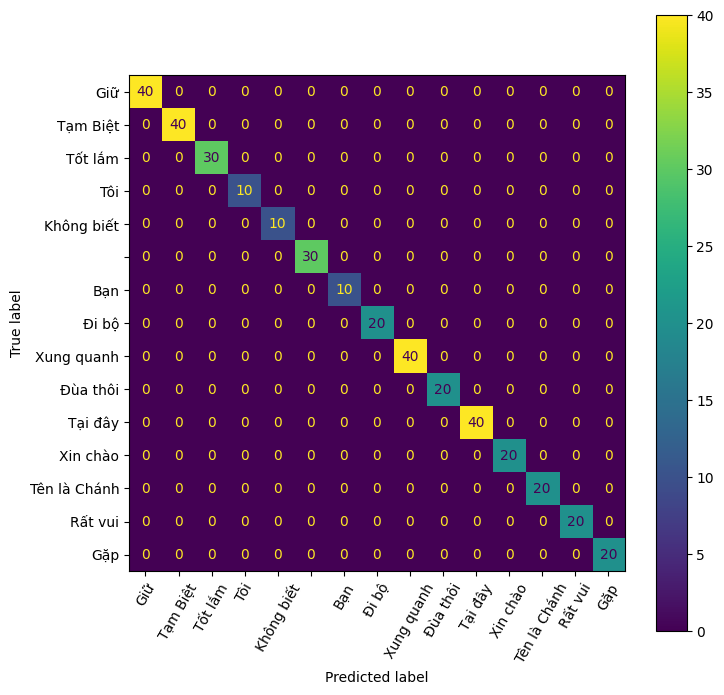

Evaluate model shift
12/12 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         Giữ       1.00      1.00      1.00        40
    Tạm Biệt       1.00      0.97      0.99        40
     Tốt lắm       1.00      0.90      0.95        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       0.77      1.00      0.87        10
       Đi bộ       1.00      1.00      1.00        20
  Xung quanh       1.00      1.00      1.00        40
    Đùa thôi       1.00      1.00      1.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       0.95      1.00      0.98        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       1.00      1.00      1.00        20

    accuracy                           0.99       370
   ma

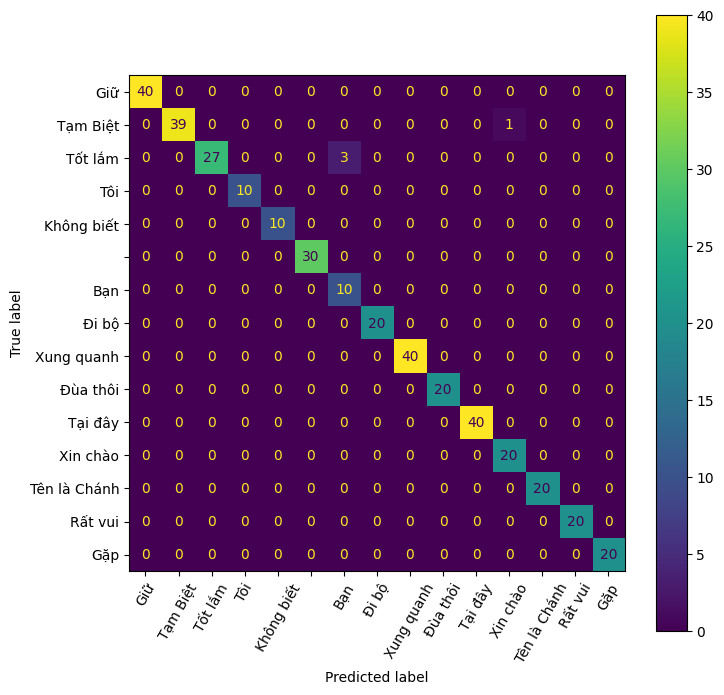

Evaluate model shift_magnitude_warp
12/12 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         Giữ       0.59      1.00      0.74        40
    Tạm Biệt       1.00      1.00      1.00        40
     Tốt lắm       1.00      0.67      0.80        30
         Tôi       1.00      1.00      1.00        10
  Không biết       1.00      1.00      1.00        10
                   1.00      1.00      1.00        30
         Bạn       1.00      1.00      1.00        10
       Đi bộ       1.00      0.20      0.33        20
  Xung quanh       1.00      0.97      0.99        40
    Đùa thôi       1.00      0.90      0.95        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       1.00      1.00      1.00        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       1.00      1.00      1.00        20
         Gặp       0.95      1.00      0.98        20

    accuracy                           0.92 

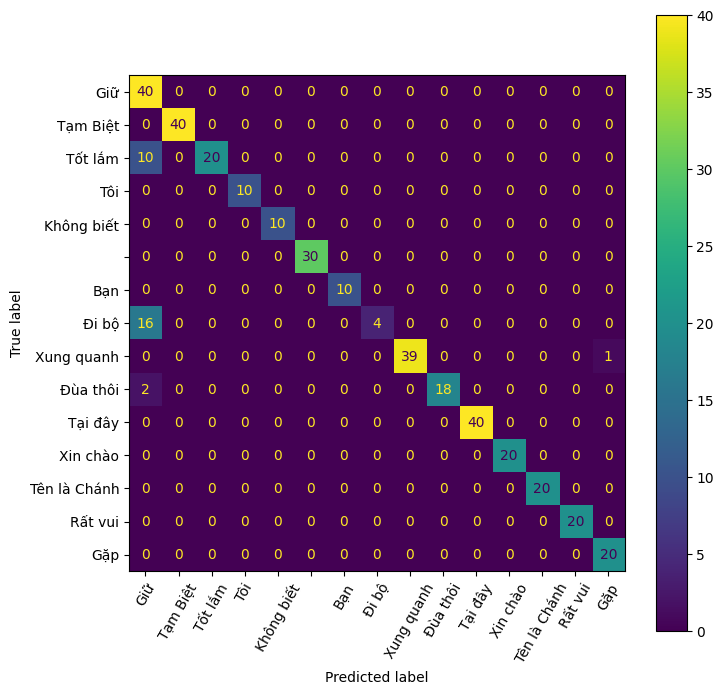

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

data_augmentation, techniques = read_enlarged_data()
models = []
history = []

scaler = StandardScaler()

# original_model = create_base_model(timesteps, n_features, num_classes)
# original_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history.append(original_model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
# models.append(original_model)


for data, technique in zip(data_augmentation, techniques):
    train_x = np.vstack([trainX, data])
    train_y = np.vstack([trainy, trainy])
    train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
    base_model = create_base_model(timesteps, n_features)
    base_model.load_weights(f"./model/SADeepConvLSTM_TransferLearning.h5", by_name=True, skip_mismatch=True)
    model = add_activation_layer(base_model, num_classes, technique)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history.append(model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
    models.append(model)
    model.save(f"./model/{model.name}_SADeepConvLSTM.h5")


plot_val_loss(models, history)

for model in models:
    testX = scaler.fit_transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    evaluate_model(model, testX, testy, class_names)

